<a href="https://colab.research.google.com/github/JhaAkansha/SnowCapMeltAnalysis/blob/main/RS_OEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install earthengine-api geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.9 MB/s eta 0:00:00


In [1]:
import ee
ee.Authenticate()
ee.Initialize(project='snowcapmelt')

In [24]:
import datetime
import matplotlib.pyplot as plt

# Arctic and Antarctic regions
arctic = ee.Geometry.Point([-45, 69]).buffer(100000)
antarctic = ee.Geometry.Point([-63.5, -73]).buffer(100000)

# NDSI calculation function
def calculate_ndsi(image, green_band, swir_band):
    ndsi = image.normalizedDifference([green_band, swir_band]).rename('NDSI')
    return image.addBands(ndsi)

# Safe median for empty image collections
def safe_median(img_collection):
    size = img_collection.size()
    return ee.Image(ee.Algorithms.If(
        size.eq(0),
        ee.Image(0),  # fallback
        img_collection.median()
    ))

# Main function to compute yearly snow cover
def get_yearly_snow_cover(start_year, end_year, region, platform='Landsat'):
    yearly_snow_stats = []

    for year in range(start_year, end_year + 1):
        start = ee.Date.fromYMD(year, 6, 1)
        end = ee.Date.fromYMD(year, 9, 30)

        if platform == 'Landsat':
            # Filter collections
            l5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)
            l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
                .filterDate(start, end).filterBounds(region)

            # Merge all
            merged = l5.merge(l7).merge(l8).merge(l9)

            # Apply NDSI using SR_B3 (green) and SR_B7 (SWIR for Landsat 5/7/8/9)
            processed = merged.map(lambda img: calculate_ndsi(img, 'SR_B3', 'SR_B7'))

        else:
            raise ValueError("Only Landsat supported for now.")

        # Threshold NDSI to get snow
        snow_ndsi = processed.map(lambda img: img.select('NDSI').gt(0.4))

        # Handle empty collection with safe median
        snow_masked = safe_median(snow_ndsi)

        # Multiply snow mask by pixel area
        pixel_area = snow_masked.multiply(ee.Image.pixelArea())

        # Reduce to get total snow-covered area in the region
        stats = pixel_area.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=30,
            maxPixels=1e13
        )

        # Safely extract snow-covered area in km²
        snow_value = ee.Algorithms.If(
            stats.contains('NDSI'),
            ee.Number(stats.get('NDSI')).divide(1e6),
            0
        )

        yearly_snow_stats.append(snow_value)

    return ee.List(yearly_snow_stats)

# === RUNNING FOR ARCTIC AND ANTARCTIC === #
years = list(range(2000, 2025))

print("Calculating Arctic snow cover...")
arctic_snow = get_yearly_snow_cover(2000, 2024, arctic, platform='Landsat')
arctic_area = arctic_snow.getInfo()  # converts ee.List to Python list

print("Calculating Antarctic snow cover...")
antarctic_snow = get_yearly_snow_cover(2000, 2024, antarctic, platform='Landsat')
antarctic_area = antarctic_snow.getInfo()
print("Arctic Snow Area (km²):", arctic_area)
print("Antarctic Snow Area (km²):", antarctic_area)

Calculating Arctic snow cover...
Calculating Antarctic snow cover...
Arctic Snow Area (km²): [11572.203509698358, 11503.952528084863, 11585.101621871609, 9820.419660450183, 11510.572300487429, 9497.523122354683, 11697.68416731777, 11675.539237948286, 11367.18616914419, 11839.847575026024, 12802.946528815413, 12639.477811680374, 12638.870749817104, 13291.38025356888, 12858.674828907719, 12887.095098216574, 13010.43737340373, 12894.582256850588, 13111.571094806384, 12985.646817845318, 12938.138253421708, 12996.438059993206, 12980.568057927965, 12920.876506075194, 13014.287790172728]
Antarctic Snow Area (km²): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


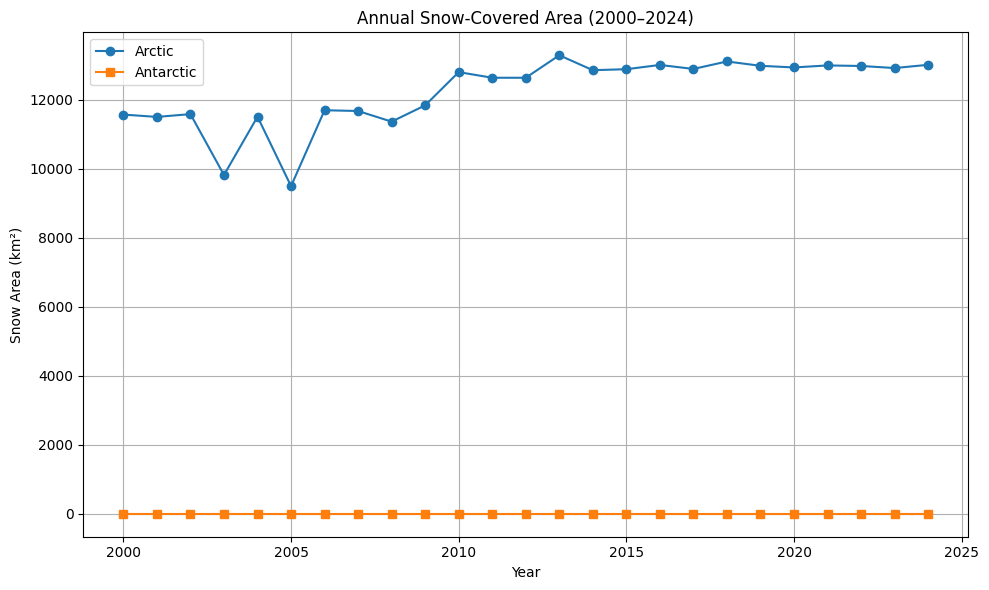

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(years, arctic_area, label='Arctic', marker='o')
plt.plot(years, antarctic_area, label='Antarctic', marker='s')
plt.title("Annual Snow-Covered Area (2000–2024)")
plt.ylabel("Snow Area (km²)")
plt.xlabel("Year")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Processing 2015...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2016...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2017...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2018...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2019...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2020...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2021...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2022...
  Greenland...OK
  Svalbard...OK
  Canadian Arctic...OK
  Antarctic Peninsula...OK
  Patagonia...OK

Processing 2023...
  Greenland...OK
  S

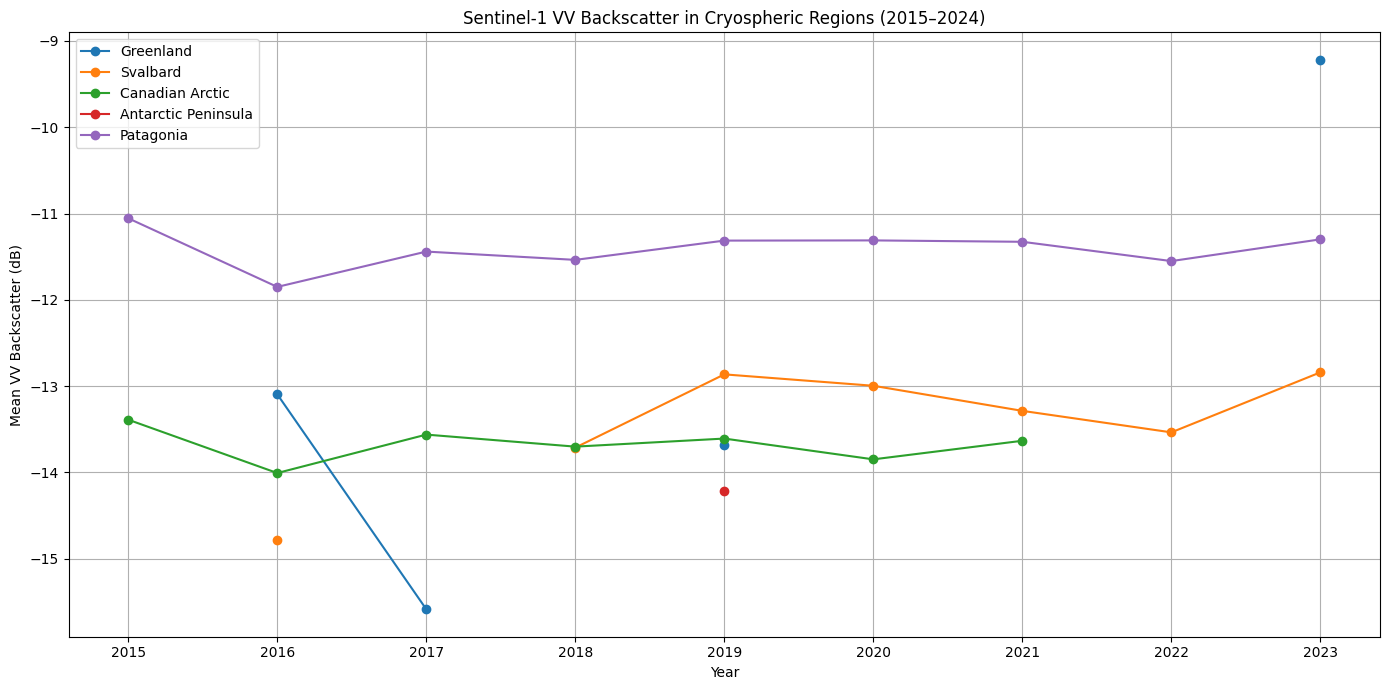

In [43]:
#Mean VV backscatter (dB)	Higher = dry snow or ice, Lower = wet/melted

# Define regions as polygons
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}

# Years to analyze
years = list(range(2015, 2024))

# Get Sentinel-1 VV backscatter
def get_s1_vv_mean(region, year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterDate(start, end) \
        .filterBounds(region) \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select('VV')

    if s1.size().getInfo() == 0:
        return None

    median = s1.median().clip(region)
    stats = median.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000,
        maxPixels=1e13,
        tileScale=8
    )
    return stats.get('VV').getInfo()

# Results dictionary
results = {name: [] for name in regions.keys()}

# Process each region
for year in years:
    print(f"\nProcessing {year}...")
    for name, geom in regions.items():
        try:
            print(f"  {name}...", end='')
            vv = get_s1_vv_mean(geom, year)
            results[name].append(vv)
            print("OK")
        except Exception as e:
            print(f"error ({e})")
            results[name].append(None)

# ---- Plot results ----
plt.figure(figsize=(14, 7))
for name, values in results.items():
    plt.plot(years, values, marker='o', label=name)

plt.title('Sentinel-1 VV Backscatter in Cryospheric Regions (2015–2024)')
plt.xlabel('Year')
plt.ylabel('Mean VV Backscatter (dB)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Landsat does not cover most of the Antarctic interior due to orbital constraints.
#most imagery is cloud-covered or unavailable during Antarctic winter.

In [ ]:
#Sentinel 1 is not optical and therefore does not give NDSI hence we use backscatter

In [5]:
#Getting data for 2000 to 2014 from MODIS since Sentinel-1 does not have data before 2015
#MODIS gives fraction of area snow-covered: 0 (none) to 1 (fully covered). Sentinel-1 VV gives backscatter (dB): useful for wet snow / ice transitions.


Processing: Greenland
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Year 2005...OK
  Year 2006...OK
  Year 2007...OK
  Year 2008...OK
  Year 2009...OK
  Year 2010...OK
  Year 2011...OK
  Year 2012...OK
  Year 2013...OK
  Year 2014...OK
  Year 2015...—
  Year 2016...—
  Year 2017...—
  Year 2018...—
  Year 2019...—
  Year 2020...—
  Year 2021...—
  Year 2022...—
  Year 2023...—
  Year 2024...—

Processing: Svalbard
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Year 2005...OK
  Year 2006...OK
  Year 2007...OK
  Year 2008...OK
  Year 2009...OK
  Year 2010...OK
  Year 2011...OK
  Year 2012...OK
  Year 2013...OK
  Year 2014...OK
  Year 2015...—
  Year 2016...—
  Year 2017...—
  Year 2018...OK
  Year 2019...OK
  Year 2020...OK
  Year 2021...OK
  Year 2022...OK
  Year 2023...OK
  Year 2024...OK

Processing: Canadian Arctic
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Ye

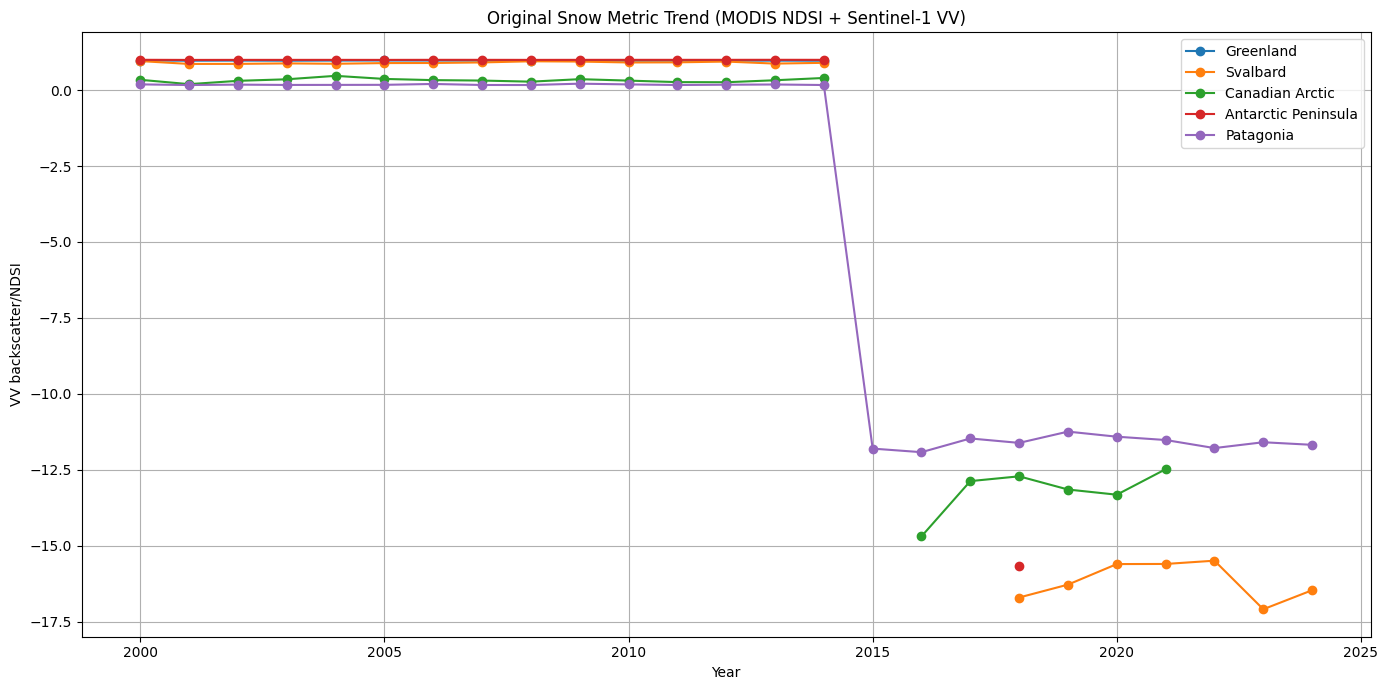

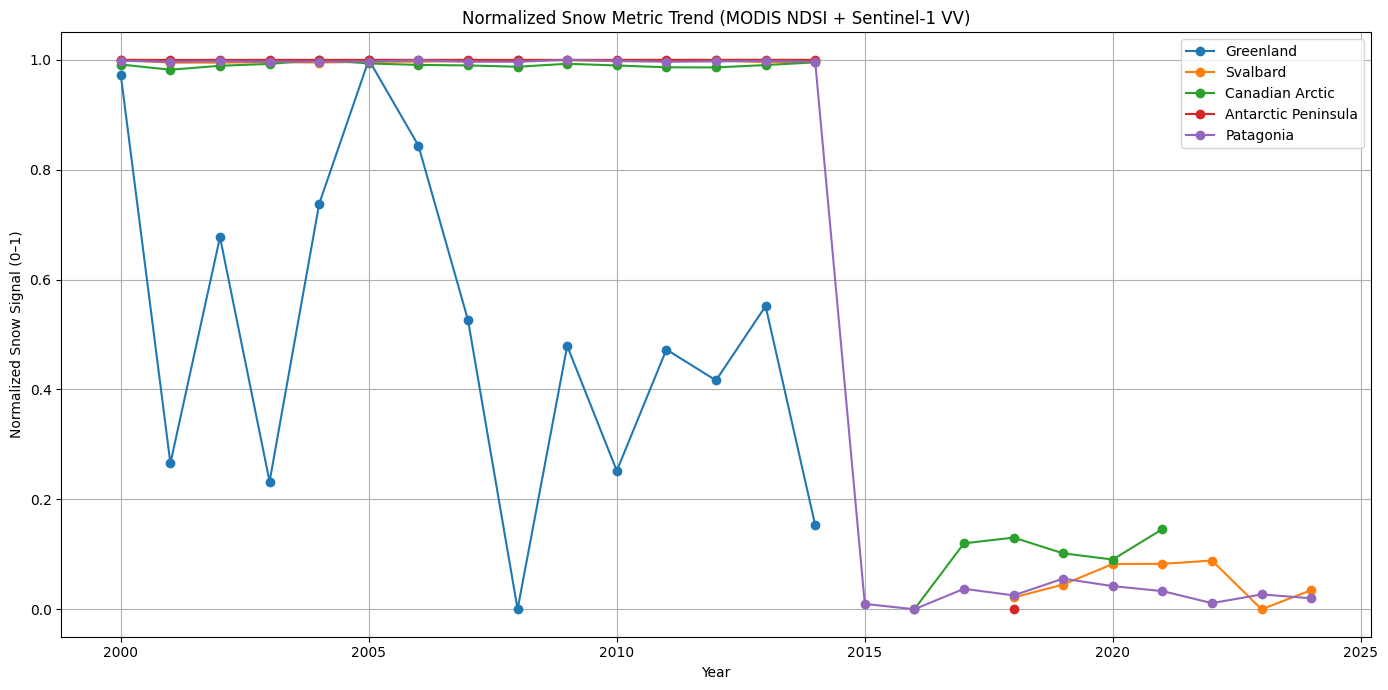

In [53]:
import ee
import matplotlib.pyplot as plt
import numpy as np

# Define regions
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}

# Years to process
years = list(range(2000, 2025))

# Function to get snow metric
def get_snow_metric(region_geom, year, region_name):
    try:
        # Set season per hemisphere
        if region_name.lower().startswith('antarctic') or region_name == 'Patagonia':
            start = f'{year}-12-01'
            end = f'{year+1}-02-28'
        else:
            start = f'{year}-06-15'
            end = f'{year}-08-15'

        # MODIS if year < 2015
        if year < 2015:
            modis = ee.ImageCollection('MODIS/006/MOD10A1') \
                .filterDate(start, end) \
                .filterBounds(region_geom) \
                .select('NDSI_Snow_Cover')
            snow = modis.map(lambda img: img.gt(0).rename('snow')).mean()
            stats = snow.reduceRegion(ee.Reducer.mean(), region_geom, 5000, maxPixels=1e13, tileScale=4)
            return stats.get('snow').getInfo()

        # Sentinel-1 VV fallback (SAR)
        s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterDate(start, end) \
            .filterBounds(region_geom) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .select('VV')

        if s1.size().getInfo() == 0:
            return None

        median = s1.median().clip(region_geom)
        stats = median.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region_geom,
            scale=5000,
            maxPixels=1e13,
            tileScale=4
        )
        value = stats.get('VV')
        return value.getInfo() if value else None

    except Exception as e:
        print(f"  Error {region_name} {year} failed: {e}")
        return None

# Run the analysis
results = {}
for region_name, region_geom in regions.items():
    print(f"\nProcessing: {region_name}")
    region_results = []
    for year in years:
        print(f"  Year {year}...", end="")
        val = get_snow_metric(region_geom, year, region_name)
        region_results.append(val)
        print("OK" if val is not None else "—")
    results[region_name] = region_results

#Plot results
plt.figure(figsize=(14, 7))
for region_name, values in results.items():
    # Only plot if at least one value is valid
    if any(v is not None and not np.isnan(v) for v in values):
        cleaned = [v if v is not None else np.nan for v in values]
        print(region_name, ": ", cleaned)
        plt.plot(years, cleaned, label=region_name, marker='o')
plt.title("Original Snow Metric Trend (MODIS NDSI + Sentinel-1 VV)")
plt.xlabel("Year")
plt.ylabel("VV backscatter/NDSI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Normalize data between 0 and 1 for each region
def normalize(series):
    arr = np.array([v if v is not None else np.nan for v in series])
    min_val = np.nanmin(arr)
    max_val = np.nanmax(arr)
    return [(v - min_val) / (max_val - min_val) if v is not None else np.nan for v in arr]

plt.figure(figsize=(14, 7))
for region_name, values in results.items():
    if any(v is not None for v in values):
        norm_vals = normalize(values)
        plt.plot(years, norm_vals, label=region_name, marker='o')

plt.title("Normalized Snow Metric Trend (MODIS NDSI + Sentinel-1 VV)")
plt.xlabel("Year")
plt.ylabel("Normalized Snow Signal (0–1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Processing: Greenland
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Year 2005...OK
  Year 2006...OK
  Year 2007...OK
  Year 2008...OK
  Year 2009...OK
  Year 2010...OK
  Year 2011...OK
  Year 2012...OK
  Year 2013...OK
  Year 2014...OK

 Processing: Svalbard
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Year 2005...OK
  Year 2006...OK
  Year 2007...OK
  Year 2008...OK
  Year 2009...OK
  Year 2010...OK
  Year 2011...OK
  Year 2012...OK
  Year 2013...OK
  Year 2014...OK

 Processing: Canadian Arctic
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Year 2005...OK
  Year 2006...OK
  Year 2007...OK
  Year 2008...OK
  Year 2009...OK
  Year 2010...OK
  Year 2011...OK
  Year 2012...OK
  Year 2013...OK
  Year 2014...OK

 Processing: Antarctic Peninsula
  Year 2000...OK
  Year 2001...OK
  Year 2002...OK
  Year 2003...OK
  Year 2004...OK
  Year 2005...OK
  Year 2006...OK
  Yea

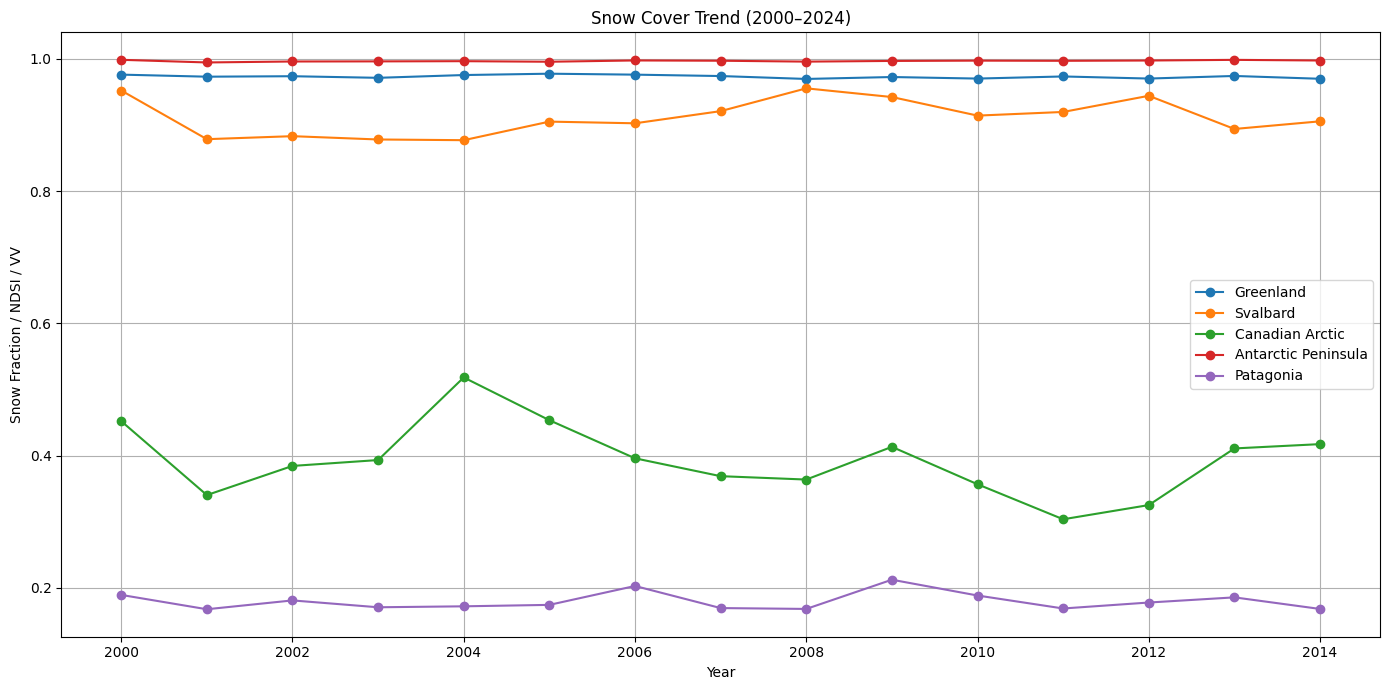

In [19]:
import ee
import matplotlib.pyplot as plt


# Define the regions
regions = {
    'Greenland': ee.Geometry.Polygon([[[-52, 60], [-52, 80], [-30, 80], [-30, 60], [-52, 60]]]),
    'Svalbard': ee.Geometry.Polygon([[[10, 76], [10, 82], [35, 82], [35, 76], [10, 76]]]),
    'Canadian Arctic': ee.Geometry.Polygon([[[-100, 65], [-100, 75], [-70, 75], [-70, 65], [-100, 65]]]),
    'Antarctic Peninsula': ee.Geometry.Polygon([[[-75, -75], [-75, -60], [-50, -60], [-50, -75], [-75, -75]]]),
    'Patagonia': ee.Geometry.Polygon([[[-75, -55], [-75, -45], [-70, -45], [-70, -55], [-75, -55]]]),
}

years = list(range(2000, 2025))

# Function to calculate snow metrics
def get_snow_metric(region_geom, year, region_name):
    try:
        # Southern hemisphere season: Dec-Feb
        if region_name.lower().startswith('antarctic') or region_name == 'Patagonia':
            start = f'{year}-12-01'
            end = f'{year+1}-02-28'
        else:
            start = f'{year}-06-01'
            end = f'{year}-08-31'

        # MODIS for 2000–2014
        if year < 2015:
            modis = ee.ImageCollection('MODIS/006/MOD10A1') \
                .filterDate(start, end) \
                .filterBounds(region_geom) \
                .select('NDSI_Snow_Cover')

            snow = modis.map(lambda img: img.gt(0).rename('snow')).mean()
            stats = snow.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region_geom,
                scale=5000,
                maxPixels=1e13,
                tileScale=8
            )
            return stats.get('snow').getInfo()

        # Sentinel-2 for 2015+
        s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filterDate(start, end) \
            .filterBounds(region_geom) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
            .select(['B3', 'B11', 'QA60']) \
            .map(lambda img: img.addBands(img.normalizedDifference(['B3', 'B11']).rename('NDSI'))) \
            .map(lambda img: img.updateMask(img.select('QA60').lt(1)))  # cloud mask

        if s2.size().getInfo() > 0:
            ndsi = s2.qualityMosaic('NDSI').select('NDSI')
            snow = ndsi.gt(0.1)
            stats = snow.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region_geom,
                scale=100,
                maxPixels=1e13,
                tileScale=8
            )
            return stats.get('NDSI').getInfo()

        # Fallback: Sentinel-1
        s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterDate(start, end) \
            .filterBounds(region_geom) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .select('VV')

        if s1.size().getInfo() > 0:
            vv = s1.median()
            stats = vv.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region_geom,
                scale=100,
                maxPixels=1e13,
                tileScale=8
            )
            return stats.get('VV').getInfo()

        return None

    except Exception as e:
        print(f"Error  {region_name} {year} failed: {e}")
        return None

# Run analysis
results = {}
for region_name, region_geom in regions.items():
    print(f"\n Processing: {region_name}")
    region_data = []
    for year in years:
        print(f"  Year {year}...", end="")
        val = get_snow_metric(region_geom, year, region_name)
        region_data.append(val)
        print("OK" if val is not None else "—")
    results[region_name] = region_data

# Plotting
plt.figure(figsize=(14, 7))
for region_name, values in results.items():
    plt.plot(years, values, label=region_name, marker='o')

plt.title("Snow Cover Trend (2000–2014)")
plt.xlabel("Year")
plt.ylabel("Snow Fraction / NDSI / VV")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()